#Import Libraries


In [12]:
import tensorflow as tf
# More imports
from tensorflow.keras.layers import Input, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os


#Data


In [7]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Mini-project/train'
valid_path = '/content/drive/MyDrive/Colab Notebooks/Mini-project/val'

In [8]:
os.listdir(train_path)

['fresh cotton leaf',
 'diseased cotton plant',
 'diseased cotton leaf',
 'fresh cotton plant']

In [9]:
os.listdir(valid_path)

['fresh cotton plant',
 'diseased cotton plant',
 'diseased cotton leaf',
 'fresh cotton leaf']

In [10]:
IMAGE_SIZE = [224, 224]

# Using Inceptionv3 architecture (Transfer Learning)





In [13]:
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [14]:
for layer in inception.layers:
    layer.trainable = False

##Obtain number of files

In [15]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')
print(f'number of image files = {len(image_files)} and number of validation files = {len(valid_image_files)}')

number of image files = 1951 and number of validation files = 324


In [16]:
folders = glob('/content/drive/MyDrive/Colab Notebooks/Mini-project/train/*')
K = len(folders)
K

4

#CNN model

In [19]:
x = Flatten()(inception.output)
x = Dense(1000,activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(500, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(200, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(100, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = Dense(50, activation = 'relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(K, activation='softmax')(x)

In [20]:
model = Model(inputs=inception.input, outputs=x)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Image augmentation

In [22]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   rotation_range=10,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
'-------------------------------------------------------------------------------'
batch_size = 16
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical'
                                                )
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = IMAGE_SIZE,
                                            batch_size = batch_size,
                                            class_mode = 'categorical'
                                            )

Found 1951 images belonging to 4 classes.
Found 324 images belonging to 4 classes.


In [23]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

##Fit Generator

In [24]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
122/122 [==============================] - 709s 6s/step - loss: 1.8138 - accuracy: 0.2640 - val_loss: 1.4725 - val_accuracy: 0.3117
Epoch 2/20
122/122 [==============================] - 36s 298ms/step - loss: 1.5328 - accuracy: 0.3393 - val_loss: 1.3682 - val_accuracy: 0.3117
Epoch 3/20
122/122 [==============================] - 37s 299ms/step - loss: 1.5470 - accuracy: 0.3157 - val_loss: 1.3533 - val_accuracy: 0.3117
Epoch 4/20
122/122 [==============================] - 37s 301ms/step - loss: 1.4478 - accuracy: 0.3321 - val_loss: 1.3555 - val_accuracy: 0.3117
Epoch 5/20
122/122 [==============================] - 37s 301ms/step - loss: 1.3986 - accuracy: 0.3460 - val_loss: 1.3399 - val_accuracy: 0.3148
Epoch 6/20
122/122 [==============================] - 36s 299ms/step - loss: 1.3530 - accuracy: 0.3772 - val_loss: 1.3077 - val_accuracy: 0.4043
Epoch 7/20
122/122 [==============================] - 36s 297ms/step - loss: 1.2567 - accuracy: 0.4254 - val_loss: 1.2574 - val_accu

#Plot results

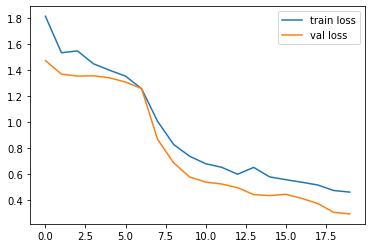

In [25]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

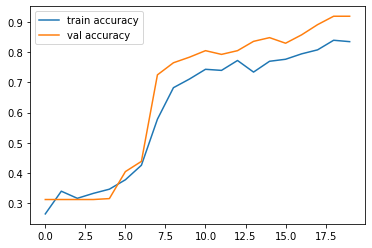

In [26]:
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

#Save Model

In [27]:
from tensorflow.keras.models import load_model

model.save('model_inceptionv3.h5')

#Predictions

In [28]:
pred = model.predict(test_set)

In [29]:
pred = np.argmax(pred, axis=1)
pred

array([2, 0, 3, 3, 0, 1, 1, 3, 3, 0, 3, 1, 1, 3, 3, 2, 3, 2, 2, 0, 2, 0,
       2, 1, 1, 0, 0, 3, 0, 0, 3, 3, 3, 3, 1, 0, 1, 3, 3, 3, 1, 3, 3, 2,
       0, 3, 3, 3, 3, 1, 1, 3, 1, 2, 2, 3, 2, 0, 1, 1, 3, 3, 0, 2, 2, 2,
       0, 3, 0, 3, 1, 2, 1, 0, 3, 3, 2, 1, 1, 1, 1, 0, 3, 0, 3, 1, 1, 0,
       3, 2, 1, 0, 2, 2, 0, 3, 3, 2, 1, 2, 1, 1, 2, 1, 1, 3, 1, 2, 1, 0,
       0, 3, 1, 3, 0, 2, 3, 3, 2, 1, 1, 0, 1, 0, 3, 1, 1, 0, 3, 1, 2, 2,
       1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 2, 2, 1, 3, 1, 0, 2, 3, 1, 2, 3, 3,
       0, 3, 1, 1, 0, 2, 2, 3, 1, 3, 2, 1, 3, 2, 1, 3, 3, 2, 1, 2, 0, 0,
       0, 3, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 2, 2, 2, 1, 1, 0, 1, 3, 0, 1,
       3, 1, 0, 0, 3, 1, 3, 3, 1, 1, 2, 3, 2, 3, 2, 3, 1, 0, 3, 2, 1, 0,
       1, 0, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 3, 1, 1, 3, 1, 3,
       2, 2, 3, 2, 1, 1, 3, 0, 1, 2, 1, 3, 1, 2, 1, 2, 3, 0, 0, 2, 2, 1,
       2, 3, 0, 3, 3, 2, 0, 3, 1, 1, 2, 1, 1, 2, 1, 2, 2, 0, 0, 2, 0, 3,
       2, 1, 0, 2, 3, 2, 2, 3, 2, 0, 3, 1, 1, 0, 2,